Load a model then use it on test images.

In [5]:
import tensorflow as tf
from glob import glob
import os.path
import cv2
import scipy.misc
import numpy as np
from helper import cut_hood
import matplotlib.pyplot as plt

TEST_DIR = '../lyft_training_data/Test'
MODEL_DIR = 'saved_models/2018-05-11-1539'
IMG_SIZE = (256, 256)

# Area of Interest percentage (from the top)
AOI_PERC = 0.83

def reshape_to_ori(mask, ori_img_shape, perc_retain):
    fin_mask = np.zeros((ori_img_shape[0], ori_img_shape[1], 4))
    scale_height = int(ori_img_shape[0] * perc_retain)
    scale_width = int(ori_img_shape[1])
    mask = cv2.resize(mask, (scale_width, scale_height), interpolation=cv2.INTER_NEAREST)
    fin_mask[0:mask.shape[0], 0:mask.shape[1], :] = mask
    return fin_mask

def gen_test_output(sess, logits, keep_prob, image_pl, data_folder, image_shape, aoi_perc=AOI_PERC):
    """
    Generate test output using the test images
    :param sess: TF session
    :param logits: TF Tensor for the logits
    :param keep_prob: TF Placeholder for the dropout keep robability
    :param image_pl: TF Placeholder for the image placeholder
    :param data_folder: Path to the folder that contains the datasets
    :param image_shape: Tuple - Shape of image
    :return: Output for for each test image
    """
    for image_file in glob(os.path.join(data_folder, '*.png')):
        ori_img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
        image = cv2.resize(cut_hood(ori_img, perc_retain=aoi_perc),
                           (image_shape[1], image_shape[0]))

        im_softmax = sess.run(
            [tf.nn.softmax(logits)],
            {keep_prob: 1.0, image_pl: [image]})
        im_softmax_road = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
        seg_road = \
          (im_softmax_road >= 0.50).reshape(image_shape[0], image_shape[1], 1)
            
        im_softmax_vehicle = im_softmax[0][:, 2].reshape(image_shape[0], image_shape[1])
        seg_vehicle = \
          (im_softmax_vehicle >= 0.50).reshape(image_shape[0], image_shape[1], 1)

        mask = np.dot(seg_road, np.array([[0, 255, 0, 127]])) + \
               np.dot(seg_vehicle, np.array([[255, 0, 0, 127]]))
        
        mask = reshape_to_ori(mask, ori_img.shape, aoi_perc)

        mask = scipy.misc.toimage(mask, mode="RGBA")
        
        street_im = scipy.misc.toimage(ori_img)
        street_im.paste(mask, box=None, mask=mask)

        yield os.path.basename(image_file), np.array(street_im)

In [6]:
# https://stackoverflow.com/questions/33759623/tensorflow-how-to-save-restore-a-model/47235448#47235448

sess = tf.Session()
signature_key = tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY

meta_graph_def = tf.saved_model.loader.load(sess,
                                            [tf.saved_model.tag_constants.SERVING], MODEL_DIR)

image_input = sess.graph.get_tensor_by_name('image_input:0')
keep_prob = sess.graph.get_tensor_by_name('keep_prob:0')
logits = sess.graph.get_tensor_by_name('logits:0')

image_outputs = gen_test_output(sess, logits, keep_prob, image_input, TEST_DIR, IMG_SIZE)

images = []
image_names = []
for name, img in image_outputs:
    image_names.append(name)
    images.append(img)

INFO:tensorflow:Restoring parameters from b'saved_models/2018-05-11-1539/variables/variables'


/home/jay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
/home/jay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


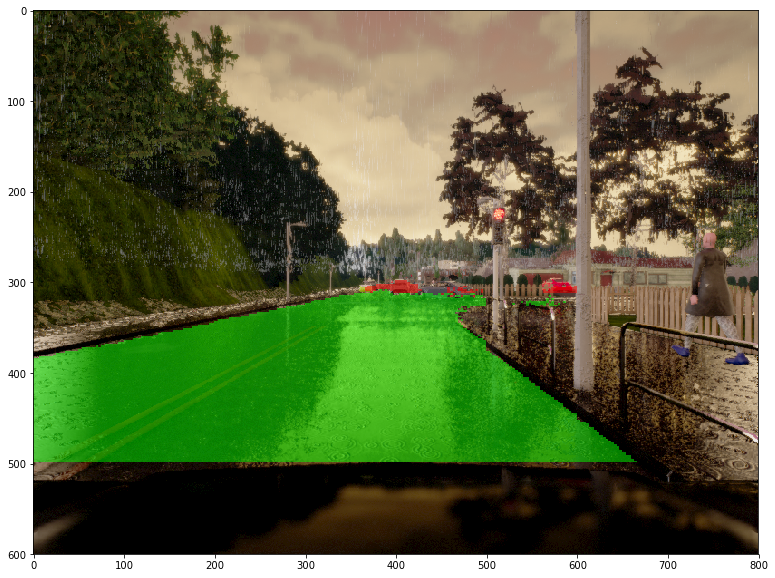

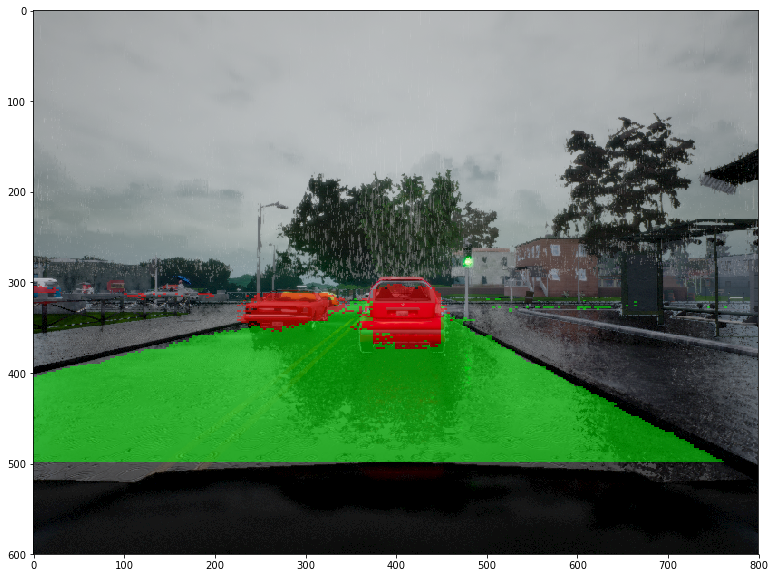

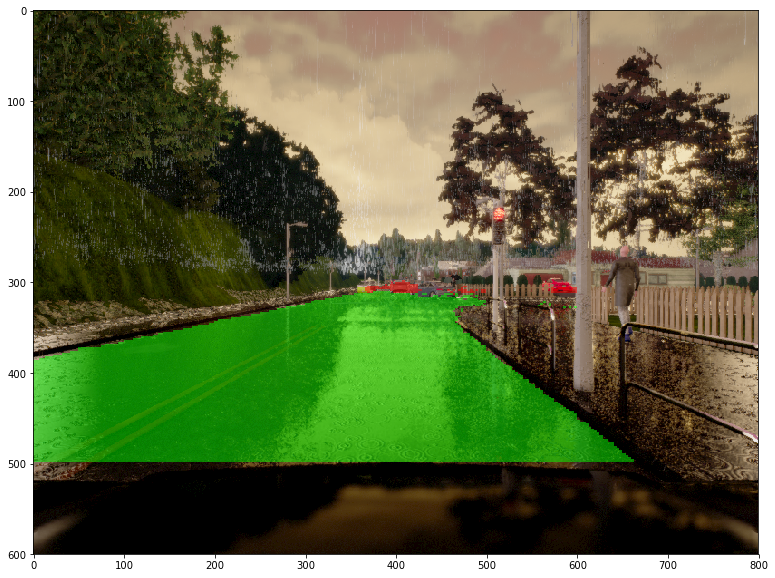

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [7]:
for img in images:
    plt.figure(figsize=(15,10))
    plt.imshow(img)
    plt.show()